# 1. Introduction

Nikki Satmaka - Batch 11

## Description

Dataset is taken from [Kaggle](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset)

Context:

This dataset contains 

### Objective

- pass

### Problem Statement

- pass

# 2. Importing Libraries

In [80]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import joblib
import re

from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Split Dataset and Standarize the Datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Neural Network
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

# Evaluate Classification Models
from sklearn.metrics import classification_report

# Useful functions
from packages.checker import check_missing
from packages.outlier_handling import outlier_summary
from packages.visualization import kdeplot, plot_loss, plot_acc
from packages.text_preprocessing import combine_text

pd.set_option('display.precision', 2)

sns.set_theme(style='darkgrid', palette='Set1')

# set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

%matplotlib inline

# 3. Data Loading

In [2]:
# load dataset
df_fake_ori = pd.read_csv("data/Fake.csv")
df_real_ori = pd.read_csv("data/True.csv")

# make a copy of the original dataframe
df_fake = df_fake_ori.copy()
df_real = df_real_ori.copy()

# display the first 5 entries of fake news data
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
# display the first 5 entries of real news data
df_real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Data Understanding

In [4]:
# check dataset shape
print(f"Fake news dataset shape: {df_fake.shape}")
print(f"Real news dataset shape: {df_real.shape}")

Fake news dataset shape: (23481, 4)
Real news dataset shape: (21417, 4)


There are 21417 instances and 4 columns of real news data\
There are 23481 instances and 4 columns of fake news data

In [5]:
# check fake news dataset info
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [6]:
# check real news dataset info
df_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


Both dataset have their date as string object. I'm going to convert them to datetime object.\
However, I'm going to combine them first. Both dataframes have the same features, so we can safely proceed.

### Combine Dataset
Since the dataset was separated between real and fake news, let's combine them into one dataframe

In [7]:
# define target variable, 0 for fake news, 1 for real news
df_fake['target'] = 0
df_real['target'] = 1

# concat datasets
df_ori = pd.concat([df_fake, df_real]).reset_index(drop=True)

# create backup
df = df_ori.copy()

# display the first five rows of the dataset
df.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [8]:
# check dataset shape
df.shape

(44898, 5)

There are 44,898 instances of data with 5 columns

In [9]:
# check missing values in dataset
check_missing(df)

,feats,tot_missing,tot_missing_pct


Great! There are no missing values

In [10]:
# check duplicate values in dataset
df[df.duplicated()]

,title,text,subject,date,target
9942,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017",0
11446,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017",0
14925,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015",0
23926,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"November 30, 2017",1
24259,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,"November 8, 2017",1
...,...,...,...,...,...
44709,France unveils labor reforms in first step to ...,PARIS (Reuters) - French President Emmanuel Ma...,worldnews,"August 31, 2017",1
44744,Guatemala top court sides with U.N. graft unit...,GUATEMALA CITY (Reuters) - Guatemala s top cou...,worldnews,"August 29, 2017",1
44771,"Europeans, Africans agree renewed push to tack...",PARIS (Reuters) - Europe s big four continen...,worldnews,"August 28, 2017",1
44834,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,worldnews,"August 25, 2017",1


We found some duplicates in our dataset. Let's drop them

In [11]:
# drop duplicates
df = df[~df.duplicated()]

In [12]:
df.shape

(44689, 5)

We now have 44,689 instances of data left

## Check for Dataset Imbalance

Check whether the target variable of the dataset is balance

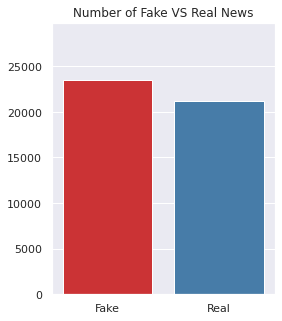

In [13]:
# check for imbalance in target variable
plt.figure(figsize=(4,5))
sns.countplot(data=df, x='target')
plt.title('Number of Fake VS Real News')
plt.xlabel(None)
plt.ylabel(None)
plt.ylim(0, df.shape[0] / 1.5)
plt.xticks([0, 1], ['Fake', 'Real'])

plt.show()

We can see that our data has similar number of fake and real news. Hence, the data is quite balanced and we won't need to oversample or undersample

## Splitting Dataset

We need to split the dataset into train and test sets before we do any EDA.\
We do our EDA on the train set so as to not have any bias towards the whole dataset.

### Split train and test set


Since the target variable is imbalanced, we use stratified sampling

In [14]:
# split sets to training+validation and testing sets
df_train_valid, df_test = train_test_split(
    df,
    test_size=0.20,
    random_state=42,
    stratify=df['target']
)

print('df_train_valid Size:', df_train_valid.shape)
print('df_test Size:', df_test.shape)

df_train_valid Size: (35751, 5)
df_test Size: (8938, 5)


### Split train and validation set


Since the target variable is imbalanced, we use stratified sampling

In [15]:
# split sets to training and validation sets
df_train, df_valid = train_test_split(
    df_train_valid,
    test_size=0.20,
    random_state=42,
    stratify=df_train_valid['target']
)

print('df_train Size:', df_train.shape)
print('df_valid Size:', df_valid.shape)

df_train Size: (28600, 5)
df_valid Size: (7151, 5)


In [16]:
# print datasets shape
print(f'df_train shape: {df_train.shape}')
print(f'df_valid shape: {df_valid.shape}')
print(f'df_test shape: {df_test.shape}')

df_train shape: (28600, 5)
df_valid shape: (7151, 5)
df_test shape: (8938, 5)


In [17]:
# backup the train set that we are gonna perform EDA on
df_train_ori = df_train.copy()

# 4. Exploratory Data Analysis

## Subjects

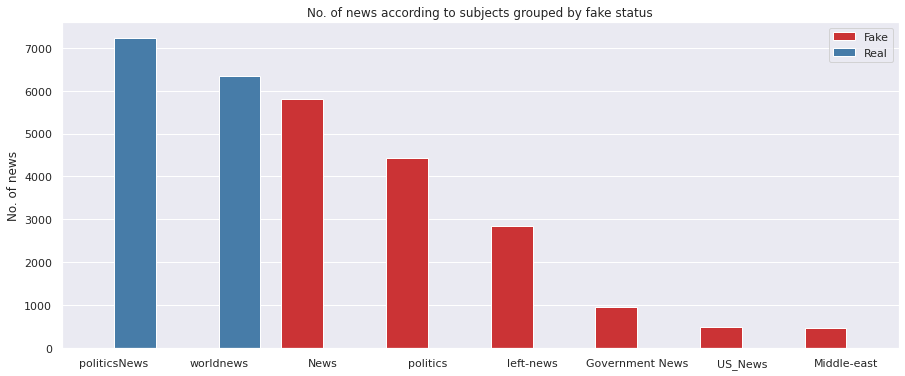

In [18]:
# plot number of news according to subjects
plt.figure(figsize=(15, 6))
sns.countplot(
    data=df_train,
    x='subject',
    hue='target',
    order=df_train['subject'].value_counts().index,
)
plt.title(f'No. of news according to subjects grouped by fake status')
plt.xlabel(None)
plt.ylabel('No. of news')

plt.legend(labels=['Fake', 'Real'])
plt.show()

We can see that real and fake news have totally different subjects. This might be a giveaway if we were to include this feature in our machine learning model later on

## Subheading 2

In [19]:
# display the first instance of the dataset
df_train.iloc[0]

title       This Fantastic Obama Speech Shows Us How A RE...
text       We just took a massive step closer to nuclear ...
subject                                                 News
date                                          August 9, 2017
target                                                     0
Name: 604, dtype: object

In [20]:
df_train.iloc[0]['title']

' This Fantastic Obama Speech Shows Us How A REAL President Would Be Acting Right Now (VIDEO)'

In [21]:
df_train.iloc[0]['text']

'We just took a massive step closer to nuclear war with North Korea, and while Secretary of State Rex Tillerson keeps trying to reassure our allies that we re trying to bring North Korea to the negotiating table rather than just annihilate the entire planet, Trump is still posturing like a male peacock fanning his tail feathers. We don t need a peacock. We need a diplomat. Here s why:BREAKING: North Korea says it will complete plan to attack waters near Guam by mid-August then wait for commander in chief s order.  The Associated Press (@AP) August 9, 2017So the Georgia Democratic Party decided to remind us of exactly what a real president would be doing right now. President Obama, who believed in the diplomacy that Trump s immature machismo says is simply weakness (because why try diplomacy when you can fan your peacock feathers and strut?), always spoke eloquently on U.S. foreign policy and on war, and emphasized the necessity of working with the rest of the world to neutralize threat

It seems like `title` and `text` are two features which make the most important content of the news. Since NLP are performed on a body of text, I'm only going to use one feature, so I'm going to combine these features into one

In [28]:
# combine title and text features
df_train_combined = combine_text(df_train, 'news', 'title', 'text')

In [83]:
df_train[df_train['date'].str.contains('http')]

,title,text,subject,date,target
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,0
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,0


In [88]:
df_test[df_test['date'].str.contains('http')]

,title,text,subject,date,target
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,0


In [30]:
df_train_combined['news'][604]

' This Fantastic Obama Speech Shows Us How A REAL President Would Be Acting Right Now (VIDEO)\nWe just took a massive step closer to nuclear war with North Korea, and while Secretary of State Rex Tillerson keeps trying to reassure our allies that we re trying to bring North Korea to the negotiating table rather than just annihilate the entire planet, Trump is still posturing like a male peacock fanning his tail feathers. We don t need a peacock. We need a diplomat. Here s why:BREAKING: North Korea says it will complete plan to attack waters near Guam by mid-August then wait for commander in chief s order.  The Associated Press (@AP) August 9, 2017So the Georgia Democratic Party decided to remind us of exactly what a real president would be doing right now. President Obama, who believed in the diplomacy that Trump s immature machismo says is simply weakness (because why try diplomacy when you can fan your peacock feathers and strut?), always spoke eloquently on U.S. foreign policy and o

# 5. Data Preprocessing

In [43]:
# convert to lowercase
text = df_train_combined['news'][5065]
text_lower = text.lower()
text_lower

" new app allegedly knows better than everyone who’s really leading the race to the white house\nwant to take part in an opinion poll on the presidential election, but the pollsters never call you? there s an app for that. it s called zip, and its developer claims its data is more accurate than that of any poll because it s not a poll, it s a conversation. it s also 100 percent anonymous so people feel more like telling the truth.zip has trump leading 64 percent to hillary s 36 percent. most of the traditional polls have hillary leading trump by anywhere from four to ten points right now. why the difference?ric milliti, zip s developer, says his app poses questions on a daily basis and then averages the answers of 100,000 users. he believes that the nature of his app means he gets a far purer result than the traditional polls: we re not a poll. we re a conversation, and 100% anonymous. people feel comfortable answering questions without fear of being bullied or being called a racist. p

In [47]:
text_punc = re.sub(r"@[A-Za-z0-9_]+", " ", text_lower)  # remove mention
text_punc = re.sub(r"#[A-Za-z0-9_]+", " ", text_punc)  # remove hashtags
text_punc = re.sub(r"\n", " ", text_punc)  # remove newline
text_punc = re.sub(r"http\S+", " ", text_punc)  # remove link
text_punc = re.sub(r"www\S+", " ", text_punc)  # remove link
text_punc = re.sub(r"[^A-Za-z\s']", " ", text_punc)  # remove non-alpha characters aside from whitespace and apostrophe

text_punc

" new app allegedly knows better than everyone who s really leading the race to the white house want to take part in an opinion poll on the presidential election  but the pollsters never call you  there s an app for that  it s called zip  and its developer claims its data is more accurate than that of any poll because it s not a poll  it s a conversation  it s also     percent anonymous so people feel more like telling the truth zip has trump leading    percent to hillary s    percent  most of the traditional polls have hillary leading trump by anywhere from four to ten points right now  why the difference ric milliti  zip s developer  says his app poses questions on a daily basis and then averages the answers of         users  he believes that the nature of his app means he gets a far purer result than the traditional polls  we re not a poll  we re a conversation  and      anonymous  people feel comfortable answering questions without fear of being bullied or being called a racist  pe

In [110]:
# declare stopwords set
stops = set(stopwords.words('english'))

# tokenize text
tokens = word_tokenize(text_punc)

# remove stopwords
text_stopped = [word for word in tokens if word not in stops]


In [113]:
# declare stemmer object
stemmer = PorterStemmer()

# stem text
text_stemmed = [stemmer.stem(word) for word in text_stopped]

In [114]:
# declare stopwords set
stops = set(stopwords.words('english'))

# declare stemmer object
stemmer = PorterStemmer()

In [122]:
df_train_combined['news'].iloc[:10].apply(lambda x:process_text(x, stops, stemmer))

604      fantast obama speech show us real presid would...
20996    disturb truth un decid muslim refuge new neigh...
34761    tillerson lavrov agre continu north korea dipl...
28665    cabinet member lobbi trump remov iraq new trav...
44461    athen macron urg renew eu democraci pari reute...
12297    gener mad dog matti part trump team prais supe...
1366     trump might vicious sabotag healthcar tri blam...
34552    santorum attend trump ralli campaign say washi...
40081    itali call confid vote senat new elector law r...
16322    trump give brutal warn lawless sanctuari citi ...
Name: news, dtype: object

## test

In [65]:
# restore the train set from the backup
df_train = df_train_ori.copy()

In [ ]:
# split between features and target
X_train = df_train.drop(['Churn'], axis=1)
y_train = df_train['Churn'].copy()

X_test = df_test.drop(['Churn'], axis=1)
y_test = df_test['Churn'].copy()

X_valid = df_valid.drop(['Churn'], axis=1)
y_valid = df_valid['Churn'].copy()

## Categorizing Features

Categorize the features based on the variable type of the features and the data it represents
- Numeric (Interval): Features which have equally spaced interval between unique values
- Categorical (Nominal): Features which have no intrinsic ordering to the unique values
- Ordinal: Features which have clear ordering but do not have equally spaced intervals between unique values

In [ ]:
# categorizing features
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

nom_cols = [
    'SeniorCitizen', 'gender', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

## Handling Outliers

In [ ]:
# check outlier summary only on numerical features
outlier_summary(X_train[num_cols], 1.5)

,feats,skew,dist,tot_outlier,tot_outlier_pct
0,tenure,0.25,normal,0,0.0
1,MonthlyCharges,-0.22,normal,0,0.0
2,TotalCharges,0.95,skewed,0,0.0


1. `Trimming`: if outliers' percentage < 5%
2. `Capping`: if outliers' percentage 5% - 15%
3. `None`: if outliers' percentage > 15%

We have no outliers for the numerical values in the dataset

## Handling Missing Values

In [ ]:
# check missing values in train set
check_missing(X_train)

,feats,tot_missing,tot_missing_pct
0,TotalCharges,7,0.16


We have 7 missing values in X_train in `TotalCharges` 

In [ ]:
# check missing values in train target
y_train.isna().sum()

0

In [ ]:
# check missing values in test set
check_missing(X_test)

,feats,tot_missing,tot_missing_pct
0,TotalCharges,3,0.21


We have 3 missing values in X_test in `TotalCharges` 

In [ ]:
# check missing values in test target
y_test.isna().sum()

0

In [ ]:
# check missing values in validation set
check_missing(X_valid)

,feats,tot_missing,tot_missing_pct
0,TotalCharges,1,0.09


We have 1 missing values in X_valid in `TotalCharges` 

In [ ]:
# check missing values in validation target
y_test.isna().sum()

0

Let's look further into the missing values

In [ ]:
# display missing values in train set
X_train[X_train['TotalCharges'].isna()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN
6754,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN


It seems that all missing values have the `tenure 0`. Let's check if this premise is correct

In [ ]:
# check if missing values instances are the same with `0` tenure instances
X_train[X_train['TotalCharges'].isna()].equals(X_train[X_train['tenure'] == 0])

True

So the premise is correct and all `0 tenure` does not have any `TotalCharges` values.\
It seems like these are instances for customers who subscribed to the services for less than a month\
However, we can see that they still have some `MonthlyCharges`. Meaning, they were still charged for the services they used\
Therefore, I'm going to impute `TotalCharges` with the value from `MonthlyCharges`

In [ ]:
# impute missing values in `TotalCharges` with values from `MonthlyCharges`
X_train = impute_total_charges(X_train)
X_test = impute_total_charges(X_test)
X_valid = impute_total_charges(X_valid)

Let's make sure there are no missing values now

In [ ]:
# check missing values in train set
check_missing(X_train)

,feats,tot_missing,tot_missing_pct


In [ ]:
# check missing values in test set
check_missing(X_test)

,feats,tot_missing,tot_missing_pct


In [ ]:
# check missing values in valid set
check_missing(X_valid)

,feats,tot_missing,tot_missing_pct


Great! We have no more missing values

## Handling Cardinality

During the EDA, I found some categories that I feel were redundant, as these informations can easily be substituted by filtering the parent feature, which is `PhoneService` and `InternetService`. Therefore, I'm going to replace these categories with `No`

In [ ]:
# replace 'No internet service' and 'No phone service' with 'No'
X_train = impute_no_phone_internet(X_train)
X_test = impute_no_phone_internet(X_test)
X_valid = impute_no_phone_internet(X_valid)

## Feature Selection

### Heatmap Correlation Matrix for Features with Number dtypes

We look at the Spearman's correlation matrix to find out the relation between features and target

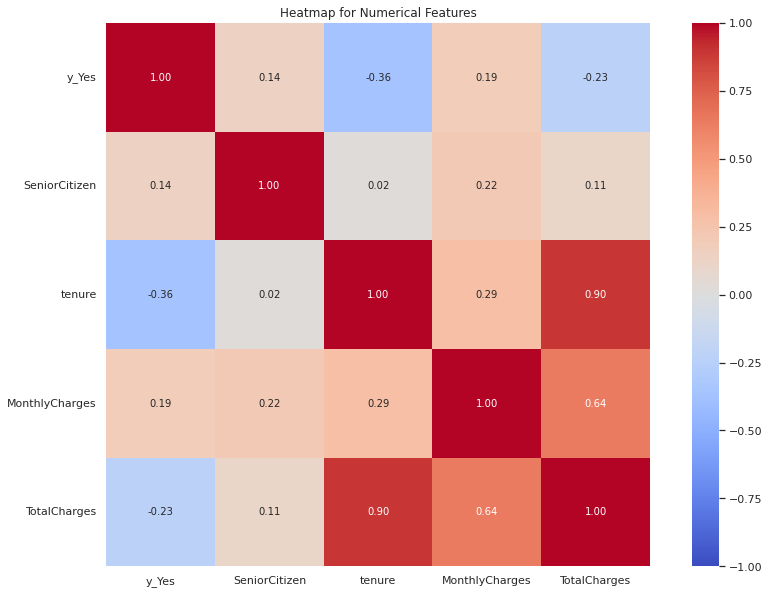

In [ ]:
# Heatmap Correlation Matrix
plt.figure(figsize=(15,10))

sns.heatmap(
    pd.concat([
        pd.get_dummies(y_train, prefix='y', drop_first=True),
        X_train.select_dtypes('number')], axis=1
    ).corr('spearman'),
    annot=True, vmin=-1, vmax=1, fmt='.2f', square=True, cmap='coolwarm')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title('Heatmap for Numerical Features')

plt.show()


- `y_yes` is a dummy variable which represents the target, with a value of `0 being no and 1 being yes`
- There are low spearman correlations amongst features and target, with the highest being `tenure`. This is consistent with our EDA that customers who stopped their subscriptions, tend to do so in their early months
- We can see that `tenure` and `TotalCharges` are highly correlated. This makes sense, since the longer a customer subscribes, the higher the total charges will be
- `MonthlyCharges` and `TotalCharges` are also highly correlated. This makes sense, since `TotalCharges` are cumulative of multiples of `MonthlyCharges`
- Therefore, I'm going to exclude `TotalCharges` as a predictor, since both `tenure` and `MonthlyCharges` represent similar information

### Categorizing Selected Features

In [ ]:
# display outlier summary
outlier_summary(X_train[num_cols], 1.5).sort_values(by='dist')

,feats,skew,dist,tot_outlier,tot_outlier_pct
0,tenure,0.25,normal,0,0.0
1,MonthlyCharges,-0.22,normal,0,0.0
2,TotalCharges,0.95,skewed,0,0.0


In [ ]:
# create list of numerical features with normal distribution
num_cols_norm = ['tenure', 'MonthlyCharges']

# create final list of nominal features
nom_cols = [
    'SeniorCitizen', 'gender', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

Great! We have finalized our feature list.
We also separated numerical features with different types of distribution just in case we want to scale them using different methods

### List of Features

These are the predictors we're going to use

In [ ]:
# print out list of predictors
print('Numerical Features:')
print(num_cols_norm)
print('=' * 50)
print('Categorical Features:')
print(nom_cols)

Numerical Features:
['tenure', 'MonthlyCharges']
Categorical Features:
['SeniorCitizen', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


## Feature Engineering

### Prepare The Necessary Objects

Declare the various objects, like scaler and encoder we might use
- All categorical features will use one hot encoder

In [ ]:
# declare standard scaler
std_sc = StandardScaler()

# declare one hot encoder
ohe_enc = OneHotEncoder(handle_unknown='ignore')

# declare label encoder
label_enc = LabelEncoder()

Create ColumnTransformer, SMOTENC objects
- In ColumnTransformer, we will design so that our dataset will have the categorical features lined up after the numerical ones

In [ ]:
# create column transformer object using min max scaler
scale = ColumnTransformer([
    ('num_norm', std_sc, num_cols_norm),
    ('nom', 'passthrough', nom_cols),
])

# create column transformer object for use after oversampling
encode = ColumnTransformer([
    ('num', 'passthrough', slice(0, 2)),
    ('nom', ohe_enc, slice(2, 18)),
])

# create smotenc object
# categorical features will be put at the end, after the numerical ones
smotenc = SMOTENC(
    categorical_features= list(range(2, 18)),
    random_state=42
)

### Scaling

We need to scale all numerical columns before oversampling

In [ ]:
# scale numeric features 
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)
X_valid_scaled = scale.transform(X_valid)

# print shape
print('X_train_scaled shape:', X_train_scaled.shape)
print('X_test_scaled shape:', X_test_scaled.shape)
print('X_valid_scaled shape:', X_valid_scaled.shape)

X_train_scaled shape: (4507, 18)
X_test_scaled shape: (1409, 18)
X_valid_scaled shape: (1127, 18)


### Oversampling

Since our data is imbalance, we need to perform oversampling

In [ ]:
# oversampling using SMOTE
X_train_balanced, y_train_balanced = smotenc.fit_resample(X_train_scaled, y_train)

# print shape after oversampling
print('X_train_balanced shape:', X_train_balanced.shape)
print('y_train_balanced shape:', y_train_balanced.shape)

X_train_balanced shape: (6622, 18)
y_train_balanced shape: (6622,)


### Encoding

In [ ]:
# encode categorical features
X_train_encoded = encode.fit_transform(X_train_balanced)
X_test_encoded = encode.transform(X_test_scaled)
X_valid_encoded = encode.transform(X_valid_scaled)

# encode labels
y_train_final = label_enc.fit_transform(y_train_balanced)
y_test_final = label_enc.transform(y_test)
y_valid_final = label_enc.transform(y_valid)

# print shape
print('X_train_encoded shape:', X_train_encoded.shape)
print('X_test_encoded shape:', X_test_encoded.shape)
print('X_valid_encoded shape:', X_valid_encoded.shape)
print('y_train_final shape:', y_train_final.shape)
print('y_test_final shape:', y_test_final.shape)
print('y_valid_final shape:', y_valid_final.shape)

X_train_encoded shape: (6622, 38)
X_test_encoded shape: (1409, 38)
X_valid_encoded shape: (1127, 38)
y_train_final shape: (6622,)
y_test_final shape: (1409,)
y_valid_final shape: (1127,)


In [ ]:
# finalize training and test sets and make sure they're float
X_train_final = X_train_encoded.astype(np.float32)
X_test_final = X_test_encoded.astype(np.float32)
X_valid_final = X_valid_encoded.astype(np.float32)

# print shape and dtype
print('X_train_final shape and dtype:', X_train_final.shape, X_train_final.dtype)
print('X_test_final shape and dtype:', X_test_final.shape, X_test_final.dtype)
print('X_valid_final shape and dtype:', X_valid_final.shape, X_valid_final.dtype)
print('y_train_final shape and dtype:', y_train_final.shape, y_train_final.dtype)
print('y_test_final shape and dtype:', y_test_final.shape, y_test_final.dtype)
print('y_valid_final shape and dtype:', y_valid_final.shape, y_valid_final.dtype)

X_train_final shape and dtype: (6622, 38) float32
X_test_final shape and dtype: (1409, 38) float32
X_valid_final shape and dtype: (1127, 38) float32
y_train_final shape and dtype: (6622,) int64
y_test_final shape and dtype: (1409,) int64
y_valid_final shape and dtype: (1127,) int64


Preprocessing is finished

# 6. Model Definition

- Target: Predicting whether the client would stop their subscription and leave the company

    The target that we're going to predict is a label, which means we are going to make a classification model.
    In this case, we want to minimize the situation in which we incorrectly predicts a customers won't stop their subscription (when the client is in fact will), or as in the statistical term, **False Negatives**.

    This prediction is made so that we can identify our customers and contact them to find out their needs and concerns as to why they might churn. This way, we can find out what to do and how to improve our services, so we may prevent them from churning.\

    We don't want to classify a customer as not likely to churn and have a false sense of security, only to find out soon after when they're stopping the subscription.

- Predictors: The features I'm going to use are
    - Numerical Features:
        - ['tenure', 'MonthlyCharges']
    - Categorical Features:
        - ['SeniorCitizen', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


- Models: I'm going to use Neural Network algorithm using keras

## Create dataset

In [ ]:
batch_size = 32
img_height = 220
img_width = 220

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

val_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
)


Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


In [ ]:
train_ds.class_names

['NORMAL', 'PNEUMONIA']

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1),
    ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True)
]

## Sequential API

In [ ]:
input = [img_height, img_width, 3]

model_evita = Sequential([
    # Conv 1
    Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=input),
    MaxPooling2D(pool_size=2, strides=2),
    # Conv 2
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input),
    MaxPooling2D(pool_size=2, strides=2),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

In [ ]:
model_evita.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 109, 109, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 107, 107, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 89888)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               1

In [ ]:
model_evita.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
epochs = 10
history = model_evita.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
 58/131 [============>.................] - ETA: 1:29 - loss: 89.0432 - accuracy: 0.7592

KeyboardInterrupt: ignored

## Sequential API

Running this model as minimal as possible. Using 1 hidden layer with 8 neurons

In [ ]:
# declare keras model using Sequential API
model_seq = keras.Sequential([
    keras.layers.Dense(units=8, activation='relu', input_shape=X_train_final.shape[1:]),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

# compile model
model_seq.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# display model summary for sequential model
model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 312       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


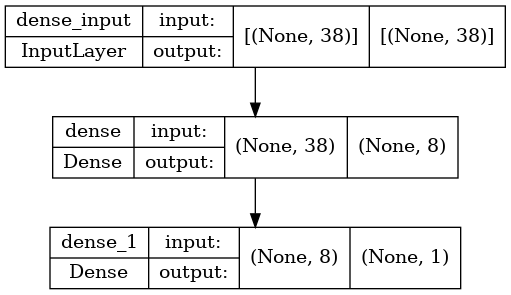

In [ ]:
# plot model architecture
keras.utils.plot_model(model_seq, to_file='report/model_seq.png', show_shapes=True)

## Functional API

Running this model as minimal as possible with the same hyperparameter as the sequential one. Using 1 hidden layer with 8 neurons

In [ ]:
# declare keras model using functional API
input_ = keras.layers.Input(shape=X_train_final.shape[1:])
hidden_1 = keras.layers.Dense(units=8, activation='relu')(input_)
output = keras.layers.Dense(units=1, activation='sigmoid')(hidden_1)
model_func = keras.Model(inputs=input_, outputs=output)

# compile model
model_func.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# display model summary for functional model
model_func.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38)]              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 312       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


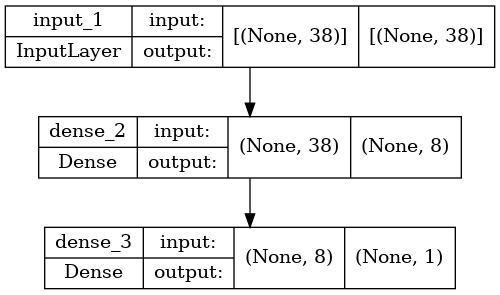

In [ ]:
# plot model architecture
keras.utils.plot_model(model_func, to_file='report/model_func.png', show_shapes=True)

## Tuning Sequential API

Attempting to improve the sequential model using initializer, regularizer, and also dropout

In [ ]:
# declare keras model using Sequential API
model_seq_tuned = keras.Sequential([
    keras.layers.Dense(
        units=8,
        activation='relu',
        input_shape=X_train_final.shape[1:],
        kernel_initializer=keras.initializers.he_normal(seed=42),
        kernel_regularizer=keras.regularizers.l2(0.01)
    ),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

# compile model
model_seq_tuned.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy']
)

# display model summary for sequential model
model_seq_tuned.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 312       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


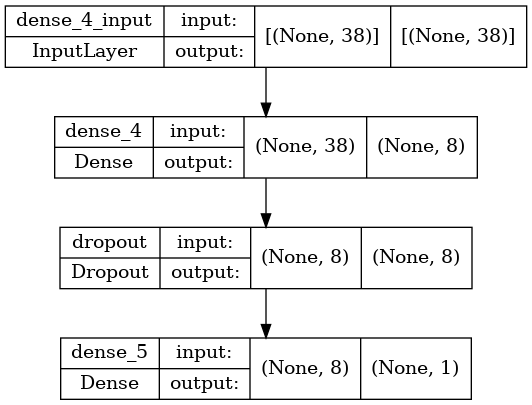

In [ ]:
# plot model architecture
keras.utils.plot_model(model_seq_tuned, to_file='report/model_seq_tuned.png', show_shapes=True)

## Tuning Functional API

Attempting to improve the model using initializer, regularizer, and also dropout. Same hyperparameter as the sequential one

In [ ]:
# declare keras model using functional API
input_ = keras.layers.Input(shape=X_train_final.shape[1:])
hidden_1 = keras.layers.Dense(
    units=8,
    activation='relu',
    kernel_initializer=keras.initializers.he_normal(seed=42),
    kernel_regularizer=keras.regularizers.l2(0.01)
)(input_)
dropout_1 = keras.layers.Dropout(rate=0.2)(hidden_1)
output = keras.layers.Dense(units=1, activation='sigmoid')(dropout_1)
model_func_tuned = keras.Model(inputs=input_, outputs=output)

# compile model
model_func_tuned.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy']
)

# display model summary for functional model
model_func_tuned.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 38)]              0         
                                                                 
 dense_6 (Dense)             (None, 8)                 312       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


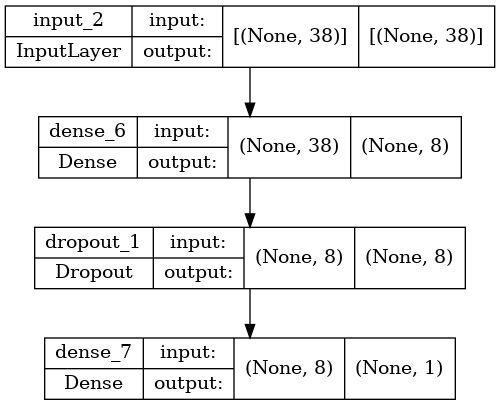

In [ ]:
# plot model architecture
keras.utils.plot_model(model_func_tuned, to_file='report/model_func_tuned.png', show_shapes=True)

## Additional objects

In [ ]:
# define callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 7. Model Training

In [ ]:
# create dictionary of models
models = {
    'sequential': model_seq,
    'sequential_tuned': model_seq_tuned,
    'functional': model_func,
    'functional_tuned': model_func_tuned
}

In [ ]:
%%time

# create dictionary to store metrics
metrics = {}

# loop through models and train
for name, model in models.items():
    # train model
    history = model.fit(
        train_dataset,
        epochs=30,
        validation_data=valid_dataset,
        callbacks=[early_stopping_cb],
        verbose=0
    )

    # store metrics
    metrics[name] = pd.DataFrame(history.history)

CPU times: user 16.4 s, sys: 4.26 s, total: 20.6 s
Wall time: 13.6 s


# 8. Model Evaluation

In [ ]:
# create dictionary to store evaluation metrics
eval_metrics = {
    'sequential': {},
    'sequential_tuned': {},
    'functional': {},
    'functional_tuned': {}
}

# loop through models and evaluate them
for name, model in models.items():
    # evaluate model
    eval_metrics[name]['loss'], eval_metrics[name]['accuracy'] = model.evaluate(
        test_dataset,
        verbose=0
    )

# create dataframe from evaluation metrics
eval_metrics_df = pd.DataFrame(eval_metrics).T

# display evaluation metrics
eval_metrics_df

,loss,accuracy
sequential,0.51,0.75
sequential_tuned,0.55,0.74
functional,0.51,0.74
functional_tuned,0.55,0.72


We can see that the loss actually increased after being tuned. The accuracy also slightly decreased

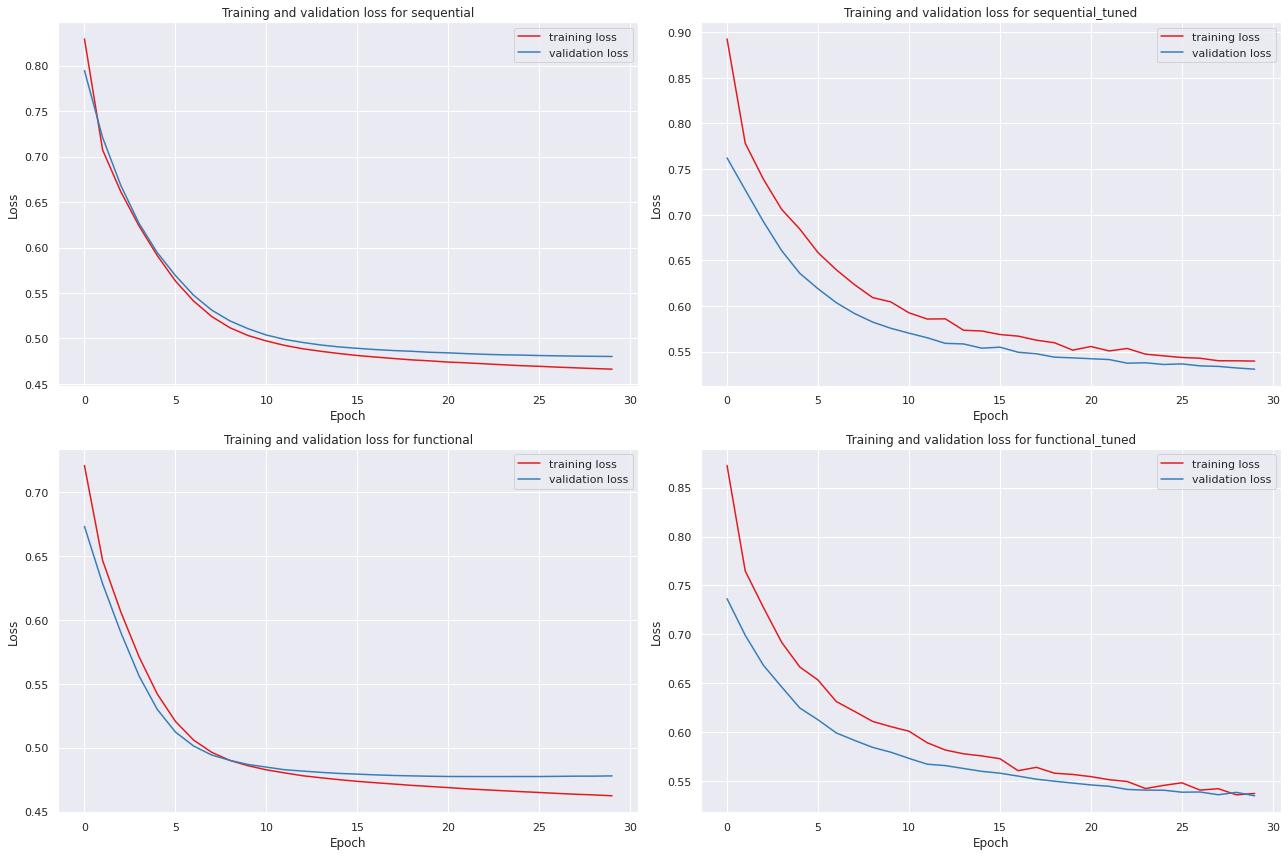

In [ ]:
plt.figure(figsize=(18, 12))

# plot the loss curves
for i, (name, metric) in enumerate(metrics.items()):
    plt.subplot(2, 2, i + 1)
    plot_loss(metric)
    plt.title(f'Training and validation loss for {name}')

plt.tight_layout()
plt.show()

- Even though the sequential and functional model uses the same hyperparameter, the results are actually slightly different
- We can see from the graph, that the functional model is a bit overfitted as we started to see the gap widening the higher the epoch.
- The sequential model also had a widening of the gap, albeit more subtly.
- The tuned models, be it sequential or functional are now a much more better fit, we could even call it a good fit. We also have the validation loss to be slightly lower than the training loss.
- We do have to note though that the absolute value of the loss increased after tuning. So we still have to see how it performs when we use it to predict the test set

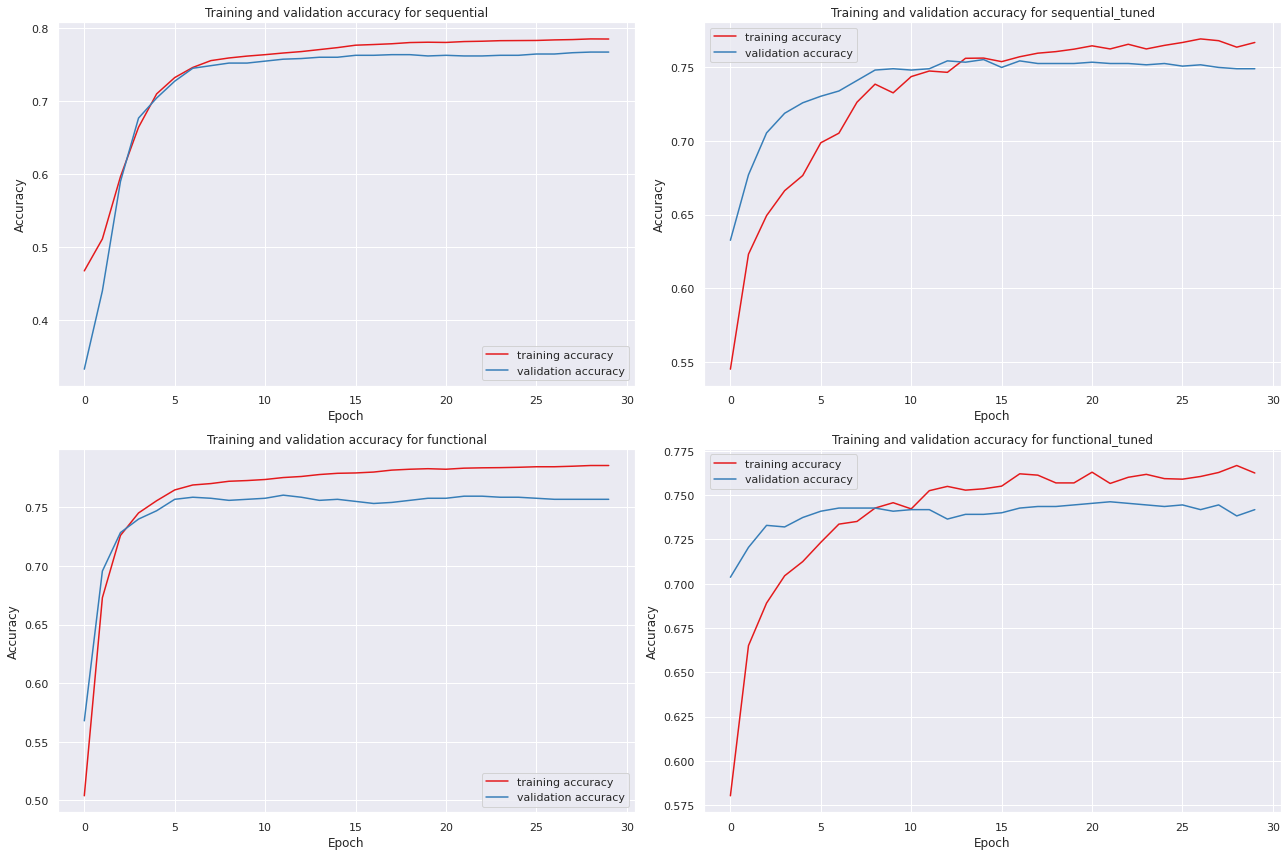

In [ ]:
plt.figure(figsize=(18, 12))

# plot the accuracy curves
for i, (name, metric) in enumerate(metrics.items()):
    plt.subplot(2, 2, i + 1)
    plot_acc(metric)
    plt.title(f'Training and validation accuracy for {name}')

plt.tight_layout()
plt.show()

- We can see that the accuracy also somewhat decreased after tuning
- The validation accuracy for the tuned models are quite high from the start but didn't increase much as it stabilized later on

## Prepare Evaluation

In [ ]:
# set threshold for prediction
threshold = 0.5

# create dictionary to store predictions:
predictions = {
    'sequential': {},
    'sequential_tuned': {},
    'functional': {},
    'functional_tuned': {},    
}

# loop through models and make predictions
for name, model in models.items():
    # make predictions for training set
    pred_train = model.predict(X_train_final).reshape(-1)
    pred_train = np.where(pred_train > threshold, 1, 0)

    # make predictions for test set
    pred_test = model.predict(X_test_final).reshape(-1)
    pred_test = np.where(pred_test > threshold, 1, 0)

    # store predictions in dictionary
    predictions[name]['train'] = pred_train
    predictions[name]['test'] = pred_test

In [ ]:
# prepare target names for classification report
target_names = ["Not Churn", "Churn"]

## Sequential API Evaluation

In [ ]:
# print classification report for sequential API
for name, preds in predictions.items():
    if 'sequential' not in name:
        continue
    for dataset, pred in preds.items():
        if dataset == 'train':
            print(f'{name} classification report for training set:')
            print(classification_report(y_train_final, pred, target_names=target_names))
        if dataset == 'test':
            print(f'{name} classification report for testing set:')
            print(classification_report(y_test_final, pred, target_names=target_names))

sequential classification report for training set:
              precision    recall  f1-score   support

   Not Churn       0.81      0.76      0.79      3311
       Churn       0.78      0.83      0.80      3311

    accuracy                           0.79      6622
   macro avg       0.79      0.79      0.79      6622
weighted avg       0.79      0.79      0.79      6622

sequential classification report for testing set:
              precision    recall  f1-score   support

   Not Churn       0.90      0.75      0.82      1035
       Churn       0.52      0.76      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.75      0.76      1409

sequential_tuned classification report for training set:
              precision    recall  f1-score   support

   Not Churn       0.82      0.73      0.77      3311
       Churn       0.76      0.84      0.80      3311

    accuracy            

- We can now see clearly that both model are not actually a very good fit. I don't think it can be called overfit either though. So I'd call it a decent fit, but it sure could be improved, as there is a `0.04` gap between training accuracy and testing accuracy
- We can also see that tuning the model successfully increased the recall score. This is important to us as we want to minimize **False Negatives**, since we need to detect potential of churning as much as possible.
- The tuned recall score is `0.79` which is quite decent
- Therefore, our model could be run on inference, but we should also strive to improve this model further

## Functional API Evaluation

In [ ]:
# print classification report for functional API
for name, preds in predictions.items():
    if 'functional' not in name:
        continue
    for dataset, pred in preds.items():
        if dataset == 'train':
            print(f'{name} classification report for training set:')
            print(classification_report(y_train_final, pred, target_names=target_names))
        if dataset == 'test':
            print(f'{name} classification report for testing set:')
            print(classification_report(y_test_final, pred, target_names=target_names))

functional classification report for training set:
              precision    recall  f1-score   support

   Not Churn       0.82      0.75      0.78      3311
       Churn       0.77      0.84      0.80      3311

    accuracy                           0.79      6622
   macro avg       0.80      0.79      0.79      6622
weighted avg       0.80      0.79      0.79      6622

functional classification report for testing set:
              precision    recall  f1-score   support

   Not Churn       0.90      0.73      0.81      1035
       Churn       0.51      0.77      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.76      1409

functional_tuned classification report for training set:
              precision    recall  f1-score   support

   Not Churn       0.85      0.70      0.77      3311
       Churn       0.75      0.87      0.81      3311

    accuracy            

- The fit situation is quite similar with the sequential models. However, the fit in the tuned model actually became even wider, with a `0.07` gap between training accuracy and testing accuracy
- Tuning the model increased the recall score substantially to `0.82`, which is good
- So this model is also good, but I'm quite concerned with the wider gap indicating overfit.

## Analysis
- Tuning successfully increased the recall score
- The fit on the functional_tuned model actually became wider, indicating that the fit became a tad worse
- Therefore, considering the fit and also the recall score, I'm choosing the **sequential_tuned** model as the best model to be saved and run

## Save The Final Model

In [ ]:
# prepare directory for saving model
model_dir = 'models'
scaler_name = 'scaler.pkl'
encoder_name = 'encoder.pkl'
model_name = 'keras_model.h5'

# create directory if it does not exist
Path(model_dir).mkdir(parents=True, exist_ok=True)

scaler_path = Path(model_dir, scaler_name)
encoder_path = Path(model_dir, encoder_name)
model_path = Path(model_dir, model_name)

# save model
joblib.dump(scale, scaler_path)
joblib.dump(encode, encoder_path)
model_seq_tuned.save(model_path)

# 9. Model Inference

## Load The Model

In [ ]:
# model location
model_dir = 'models'
scaler_name = 'scaler.pkl'
encoder_name = 'encoder.pkl'
model_name = 'keras_model.h5'

# create path object
scaler_path = Path(model_dir, scaler_name)
encoder_path = Path(model_dir, encoder_name)
model_path = Path(model_dir, model_name)

# load model
scaler = joblib.load(scaler_path)
encoder = joblib.load(encoder_path)
model = keras.models.load_model(model_path)

## Prepare Data For Inferencing

In [ ]:
# prepare data for inferencing
new_data = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 12,
    'PhoneService': 'No',
    'MultipleLines': 'No phone service',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 50,
    'TotalCharges': 600,
}

new_data_2 = {
    'gender': 'Male',
    'SeniorCitizen': 0,
    'Partner': 'No',
    'Dependents': 'No',
    'tenure': 41,
    'PhoneService': 'Yes',
    'MultipleLines': 'Yes',
    'InternetService': 'No',
    'OnlineSecurity': 'No internet service',
    'OnlineBackup': 'No internet service',
    'DeviceProtection': 'No internet service',
    'TechSupport': 'No internet service',
    'StreamingTV': 'No internet service',
    'StreamingMovies': 'No internet service',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Bank transfer (automatic)',
    'MonthlyCharges': 25.25,
    'TotalCharges': 996.45,
}


# create a list for each value in the data dictionary
for key, value in new_data.items():
    new_data[key] = [value]
    
# append new values to the data dictionary
for key, value in new_data.items():
    value.append(new_data_2[key])

# create dataframe for inferencing
new_data = pd.DataFrame(new_data)

In [ ]:
# display dataframe for inferencing
new_data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,12,No,No phone service,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,50.00,600.00
1,Male,0,No,No,41,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45


## Inferencing

In [ ]:
# impute missing values
new_data_prepared = impute_total_charges(new_data)

# impute no phone service and no internet service with no
new_data_prepared = impute_no_phone_internet(new_data_prepared)

# print shape of prepared data
print(new_data_prepared.shape)

(2, 19)


In [ ]:
%%time

# set threshold for prediction
threshold = 0.5

# scale inference set
new_data_scaled = scaler.transform(new_data_prepared)

# encode inference set
new_data_encoded = encoder.transform(new_data_scaled)

# cast as float32
new_data_final = new_data_encoded.astype(np.float32)

# predict inference set using the final model
y_pred_new = model.predict(new_data_final).reshape(-1)
y_pred_new = np.where(y_pred_new > threshold, 1, 0)

CPU times: user 54.5 ms, sys: 18.3 ms, total: 72.8 ms
Wall time: 69.1 ms


In [ ]:
# create dataframe with predictions
new_data['pred'] = y_pred_new

# display inference set
new_data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,pred
0,Female,0,Yes,No,12,No,No phone service,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,50.00,600.00,1
1,Male,0,No,No,41,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45,0


Model successfully run on inference dataset

# 10. Conclusion

## On EDA
- Most customers do not churn. Only around 30% customers eventually leave the company. This is pretty good, but we should strive to decrease it
- The number of customers who are male are about equal to those who are female, and they have similar likelihood of churning
- There are more Non-Senior citizens than Seniors and the Senior Citizens are more likely to churn
- The number of customers who have a partner and those who don't are about equal. Customers who do not have a partner are more likely to churn
- Most customers do not have any dependents. Customers who do not have dependents are more likely to churn
- The majority of our customers subscribe to a Phone Service.
- All customers who do not subscribe to a Phone Service, subscribes to DSL internet service
- Those who subscribe to a Phone Service, usually have a Fiber optic as well. This might be a packaged deal where a fiber optic users get a free or discounted phone service
- However, customers who use Fiber optic have about double the likelihood of churning compared to customers who use DSL, and about five times to that of  cutomers who only have a phone service
- Most customers do not have multiple phone lines
- The majority of our customers who have multiple phone lines, uses fiber optic internet service
- Most people who use DSL do not subscribe to additional services.  However, we do have to note that the number of customers who subscribe to online security and tech support are also about equal to those who don't
- Contrary to the DSL users, most Fiber optic users do not subscribe to online security and tech support. Is this because Fiber optic is less prone to cyber attacks, so they opted out of those additional services? We need more information on this. We could ask the online security specialist
- Fiber optics customers tend to subscribe to third-party streaming TV and streaming Movies services. This might be because they have faster, more reliable internet connection and they're also more well-off. So they want better entertainment
- Most people are on a month-to-month contract. I don't think this is a good way to retain customers, as shown that they have a higher likelihood of churning
- Customers on a two-year contract retain the customers best, with very low chance of churning.
- Most people use paperless billing and it also has a higher chance of churning compared to those who use paper billing.
- Most people use electronic check as their payment method. This isn't good for customer retention as the customers using this payment method have a higher likelihood of churning
- The data design have some of what I would deemed redundant categories like `No phone service` and `No internet service`, as these can be implied by the situation of their respective parent features of `PhoneService` and `InternetService`. However, separating them like that does make the data easier to be seen and analyze at a glance

## On Modeling
- The data is very imbalance. Hence the need for oversampling
- All the models have quite a decent fit, be it the base or the tuned models. However, the functional model actually became slightly more overfit after tuning, even though it did increase the recall score quite moderately
- Tuning also successfully increased the recall score, which is the metric we deemed important in this research
- Therefore, our model is quite okay with a `79%` recall score.

## Implication
- We cannot please everybody. However, we should still strive to be the best solution for our customers as a phone and internet service providers
- By learning from data, we can predict whether a client is dissatisfied with our services and more likely to stop their subscriptions
- This way, we can identify our customers and contact them to find out their needs and concerns as to why they might churn. Then, we can find out what to do and how to improve our services, so we may prevent them from churning.
- However, we want to minimize the event where we misclassify a customer as unlikely to churn, and have a false sense of security, while in all actuality, we should contact them right away and attempt to find out what's wrong, then retain them. This event, in statistical term, is called *False Negative*. This is the event we want to minimize
- Our model is quite decent at predicting this, having only a `79%` rate, so it may be run, but we still need to aim to improve it gradually
- Contact those customers who are more likely to churn and offer them to:
  - Switch to a two-year contract
  - Switch to automatic bank transfer or credit card payment method
  - If they still want to stop their subscriptions, offer them some kind of promotions or discounts while pushing them to use the two options mentioned above. The promotions and discounts will have to be discussed by the marketing department
  - Offer them to downgrade to a phone only service. This way we can still retain the clients 
  - Ask for feedback on what we can improve from our services

## Future Improvement
- Consider adding more data so the model could learn more
- Consider tweaking other hyperparameters like learning rate, batch normalization, optimizers, and so on
- Consider dropping some features which might not be significant to the target variable, such as `gender`, where each gender have about equal chance of churning
- Consider dropping some features which might be related to each other. Like the additional internet services, such as `StreamingTV` and `StreamingMovies`
- Consider keeping the deemed-redundant categories of `No phone service` and `No internet service`